# Preparation des Donnees et Data Generator

Ce notebook prepare les donnees pour l'entrainement du modele de segmentation.

## Objectifs
- Creer un data generator Keras efficace
- Implementer la conversion des 34 classes vers 8 categories
- Gerer le redimensionnement des images
- Implementer la data augmentation
- Preparer les ensembles train/val/test

## 1. Imports et Configuration

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")

2026-01-16 11:02:45.790902: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.20.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Configuration
DATA_DIR = Path('../data')
IMAGES_DIR = DATA_DIR / 'leftImg8bit'
LABELS_DIR = DATA_DIR / 'gtFine'

# Parametres d'entrainement
IMG_HEIGHT = 256
IMG_WIDTH = 512
N_CLASSES = 8
BATCH_SIZE = 8

print(f"Taille des images: {IMG_WIDTH}x{IMG_HEIGHT}")
print(f"Nombre de classes: {N_CLASSES}")
print(f"Batch size: {BATCH_SIZE}")

Taille des images: 512x256
Nombre de classes: 8
Batch size: 8


## 2. Configuration des classes

In [3]:
# Les 8 categories principales
CATEGORIES = {
    0: {'name': 'void', 'color': (0, 0, 0)},
    1: {'name': 'flat', 'color': (128, 64, 128)},
    2: {'name': 'construction', 'color': (70, 70, 70)},
    3: {'name': 'object', 'color': (153, 153, 153)},
    4: {'name': 'nature', 'color': (107, 142, 35)},
    5: {'name': 'sky', 'color': (70, 130, 180)},
    6: {'name': 'human', 'color': (220, 20, 60)},
    7: {'name': 'vehicle', 'color': (0, 0, 142)}
}

# Mapping des 34 classes originales vers les 8 categories
LABEL_TO_CATEGORY = {
    0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0,  # void
    7: 1, 8: 1, 9: 1, 10: 1,                     # flat
    11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2,   # construction
    17: 3, 18: 3, 19: 3, 20: 3,                  # object
    21: 4, 22: 4,                                # nature
    23: 5,                                       # sky
    24: 6, 25: 6,                                # human
    26: 7, 27: 7, 28: 7, 29: 7, 30: 7, 31: 7, 32: 7, 33: 7,  # vehicle
}

# Creer une LUT (Look-Up Table) pour conversion rapide
LUT = np.zeros(256, dtype=np.uint8)
for label_id, cat_id in LABEL_TO_CATEGORY.items():
    LUT[label_id] = cat_id

print("Look-Up Table creee pour conversion rapide des labels")

Look-Up Table creee pour conversion rapide des labels


In [4]:
# Poids de classe (calcules dans le notebook d'exploration)
# Ces poids aident a gerer le desequilibre des classes
CLASS_WEIGHTS = {
    0: 0.1,    # void - poids faible car on l'ignore souvent
    1: 0.5,    # flat - tres frequent
    2: 0.6,    # construction - frequent
    3: 1.0,    # object - moins frequent
    4: 0.7,    # nature - assez frequent
    5: 0.8,    # sky - moderement frequent
    6: 1.0,    # human - rare mais important
    7: 1.0,    # vehicle - important pour conduite autonome
}

# Convertir en array pour Keras
class_weights_array = np.array([CLASS_WEIGHTS[i] for i in range(N_CLASSES)])
print("Poids de classe:", class_weights_array)

Poids de classe: [0.1 0.5 0.6 1.  0.7 0.8 1.  1. ]


## 3. Collecte des chemins de fichiers

In [5]:
def collect_data_paths(split='train'):
    """
    Collecte tous les chemins images/labels pour un split donne.
    
    Args:
        split: 'train', 'val', ou 'test'
        
    Returns:
        Liste de dictionnaires avec chemins image et label
    """
    data = []
    split_dir = IMAGES_DIR / split
    
    for city_dir in sorted(split_dir.iterdir()):
        if not city_dir.is_dir():
            continue
            
        city_name = city_dir.name
        
        for img_path in sorted(city_dir.glob('*_leftImg8bit.png')):
            # Construire le chemin du label
            img_name = img_path.stem.replace('_leftImg8bit', '')
            label_path = LABELS_DIR / split / city_name / f"{img_name}_gtFine_labelIds.png"
            
            if label_path.exists():
                data.append({
                    'image': str(img_path),
                    'label': str(label_path),
                    'city': city_name,
                    'name': img_name
                })
    
    return data

# Collecter les donnees pour chaque split
train_data = collect_data_paths('train')
val_data = collect_data_paths('val')
test_data = collect_data_paths('test')

print(f"Train: {len(train_data)} images")
print(f"Val: {len(val_data)} images")
print(f"Test: {len(test_data)} images")

Train: 2975 images
Val: 500 images
Test: 1525 images


In [6]:
# Sauvegarder les chemins dans des fichiers CSV pour reference
def save_data_paths(data, filename):
    df = pd.DataFrame(data)
    df.to_csv(DATA_DIR / filename, index=False)
    print(f"Sauvegarde: {filename}")

save_data_paths(train_data, 'train_paths.csv')
save_data_paths(val_data, 'val_paths.csv')
save_data_paths(test_data, 'test_paths.csv')

Sauvegarde: train_paths.csv
Sauvegarde: val_paths.csv
Sauvegarde: test_paths.csv


## 4. Fonctions de preprocessing

In [7]:
def load_image(path, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    """
    Charge et redimensionne une image.
    
    Args:
        path: Chemin vers l'image
        target_size: (height, width)
        
    Returns:
        Image normalisee (0-1) de shape (H, W, 3)
    """
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (target_size[1], target_size[0]), interpolation=cv2.INTER_LINEAR)
    img = img.astype(np.float32) / 255.0
    return img

def load_label(path, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    """
    Charge et convertit un mask de labels en 8 categories.
    
    Args:
        path: Chemin vers le mask
        target_size: (height, width)
        
    Returns:
        Mask de shape (H, W) avec valeurs 0-7
    """
    # Charger le mask original (valeurs 0-33)
    mask = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    
    # Redimensionner avec interpolation nearest pour garder les labels discrets
    mask = cv2.resize(mask, (target_size[1], target_size[0]), interpolation=cv2.INTER_NEAREST)
    
    # Convertir vers 8 categories avec la LUT
    mask = LUT[mask]
    
    return mask

def mask_to_onehot(mask, n_classes=N_CLASSES):
    """
    Convertit un mask en representation one-hot.
    
    Args:
        mask: Mask de shape (H, W) avec valeurs 0 a n_classes-1
        n_classes: Nombre de classes
        
    Returns:
        Mask one-hot de shape (H, W, n_classes)
    """
    return np.eye(n_classes, dtype=np.float32)[mask]

# Test des fonctions
sample = train_data[0]
img = load_image(sample['image'])
mask = load_label(sample['label'])

print(f"Image shape: {img.shape}, dtype: {img.dtype}, range: [{img.min():.2f}, {img.max():.2f}]")
print(f"Mask shape: {mask.shape}, dtype: {mask.dtype}, unique values: {np.unique(mask)}")

Image shape: (256, 512, 3), dtype: float32, range: [0.06, 1.00]
Mask shape: (256, 512), dtype: uint8, unique values: [0 1 2 3 4 5 6 7]


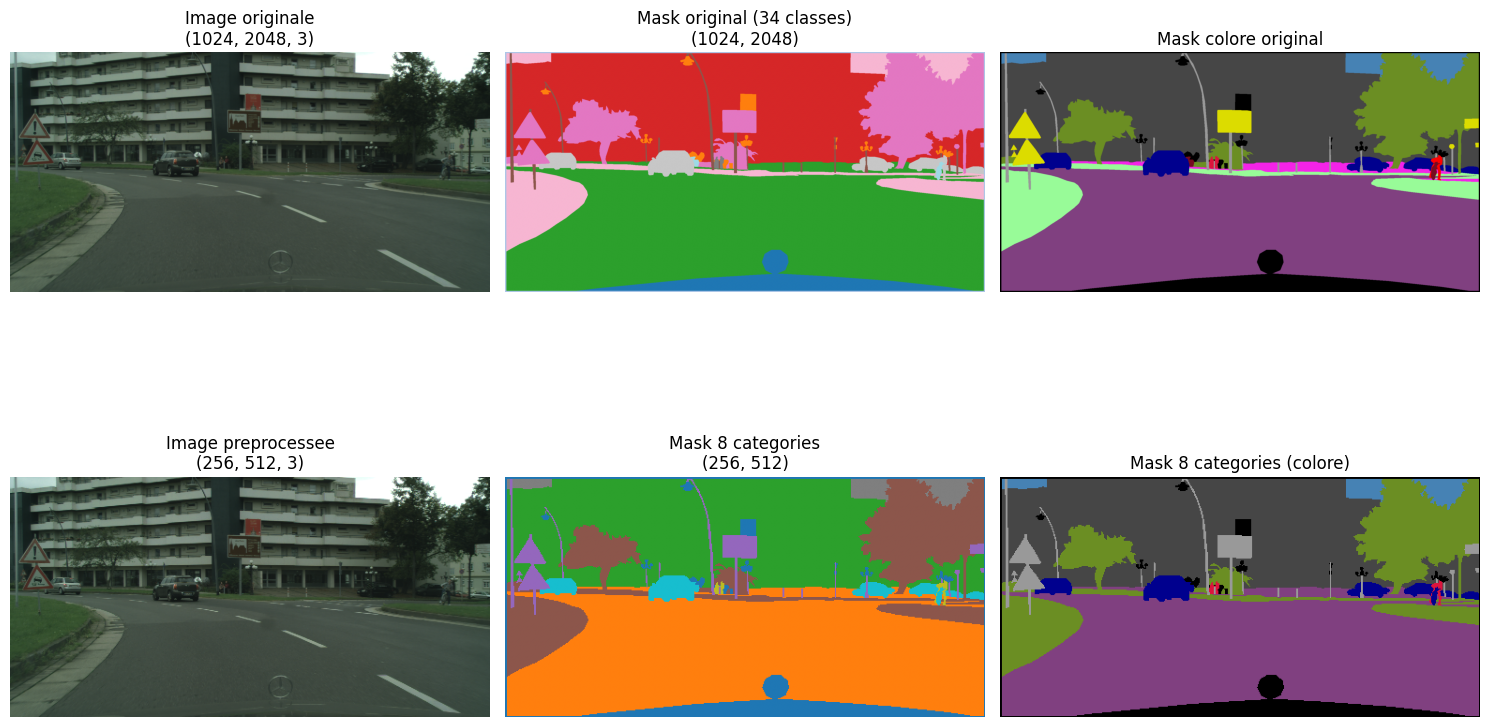

In [8]:
# Visualiser un exemple pretraite
def visualize_preprocessing(sample):
    """Visualise l'effet du preprocessing sur une image."""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Image originale
    img_orig = cv2.imread(sample['image'])
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    axes[0, 0].imshow(img_orig)
    axes[0, 0].set_title(f"Image originale\n{img_orig.shape}")
    axes[0, 0].axis('off')
    
    # Mask original
    mask_orig = cv2.imread(sample['label'], cv2.IMREAD_GRAYSCALE)
    axes[0, 1].imshow(mask_orig, cmap='tab20')
    axes[0, 1].set_title(f"Mask original (34 classes)\n{mask_orig.shape}")
    axes[0, 1].axis('off')
    
    # Mask original avec colormap
    mask_color_orig = cv2.imread(sample['label'].replace('labelIds', 'color'))
    if mask_color_orig is not None:
        mask_color_orig = cv2.cvtColor(mask_color_orig, cv2.COLOR_BGR2RGB)
        axes[0, 2].imshow(mask_color_orig)
    axes[0, 2].set_title("Mask colore original")
    axes[0, 2].axis('off')
    
    # Image preprocessee
    img = load_image(sample['image'])
    axes[1, 0].imshow(img)
    axes[1, 0].set_title(f"Image preprocessee\n{img.shape}")
    axes[1, 0].axis('off')
    
    # Mask 8 categories
    mask = load_label(sample['label'])
    axes[1, 1].imshow(mask, cmap='tab10', vmin=0, vmax=7)
    axes[1, 1].set_title(f"Mask 8 categories\n{mask.shape}")
    axes[1, 1].axis('off')
    
    # Mask colore avec nos categories
    mask_colored = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for cat_id, info in CATEGORIES.items():
        mask_colored[mask == cat_id] = info['color']
    axes[1, 2].imshow(mask_colored)
    axes[1, 2].set_title("Mask 8 categories (colore)")
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_preprocessing(train_data[0])

## 5. Data Augmentation

In [9]:
class DataAugmentation:
    """
    Classe pour appliquer des augmentations coherentes sur image et mask.
    """
    
    def __init__(self, 
                 horizontal_flip=True,
                 brightness_range=(0.8, 1.2),
                 contrast_range=(0.8, 1.2),
                 saturation_range=(0.8, 1.2),
                 rotation_range=10,
                 zoom_range=(0.9, 1.1)):
        
        self.horizontal_flip = horizontal_flip
        self.brightness_range = brightness_range
        self.contrast_range = contrast_range
        self.saturation_range = saturation_range
        self.rotation_range = rotation_range
        self.zoom_range = zoom_range
    
    def __call__(self, image, mask):
        """
        Applique les augmentations.
        
        Args:
            image: Image numpy (H, W, 3) normalisee [0, 1]
            mask: Mask numpy (H, W) avec valeurs entieres
            
        Returns:
            image_aug, mask_aug
        """
        # Flip horizontal
        if self.horizontal_flip and np.random.random() > 0.5:
            image = np.fliplr(image)
            mask = np.fliplr(mask)
        
        # Ajustements de couleur (uniquement sur l'image)
        if self.brightness_range:
            factor = np.random.uniform(*self.brightness_range)
            image = np.clip(image * factor, 0, 1)
        
        if self.contrast_range:
            factor = np.random.uniform(*self.contrast_range)
            mean = np.mean(image, axis=(0, 1), keepdims=True)
            image = np.clip((image - mean) * factor + mean, 0, 1)
        
        # Rotation legere
        if self.rotation_range:
            angle = np.random.uniform(-self.rotation_range, self.rotation_range)
            h, w = image.shape[:2]
            M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
            image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)
            mask = cv2.warpAffine(mask, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT)
        
        return image.astype(np.float32), mask

# Test de l'augmentation
augmenter = DataAugmentation()
print("Data augmentation configuree")

Data augmentation configuree


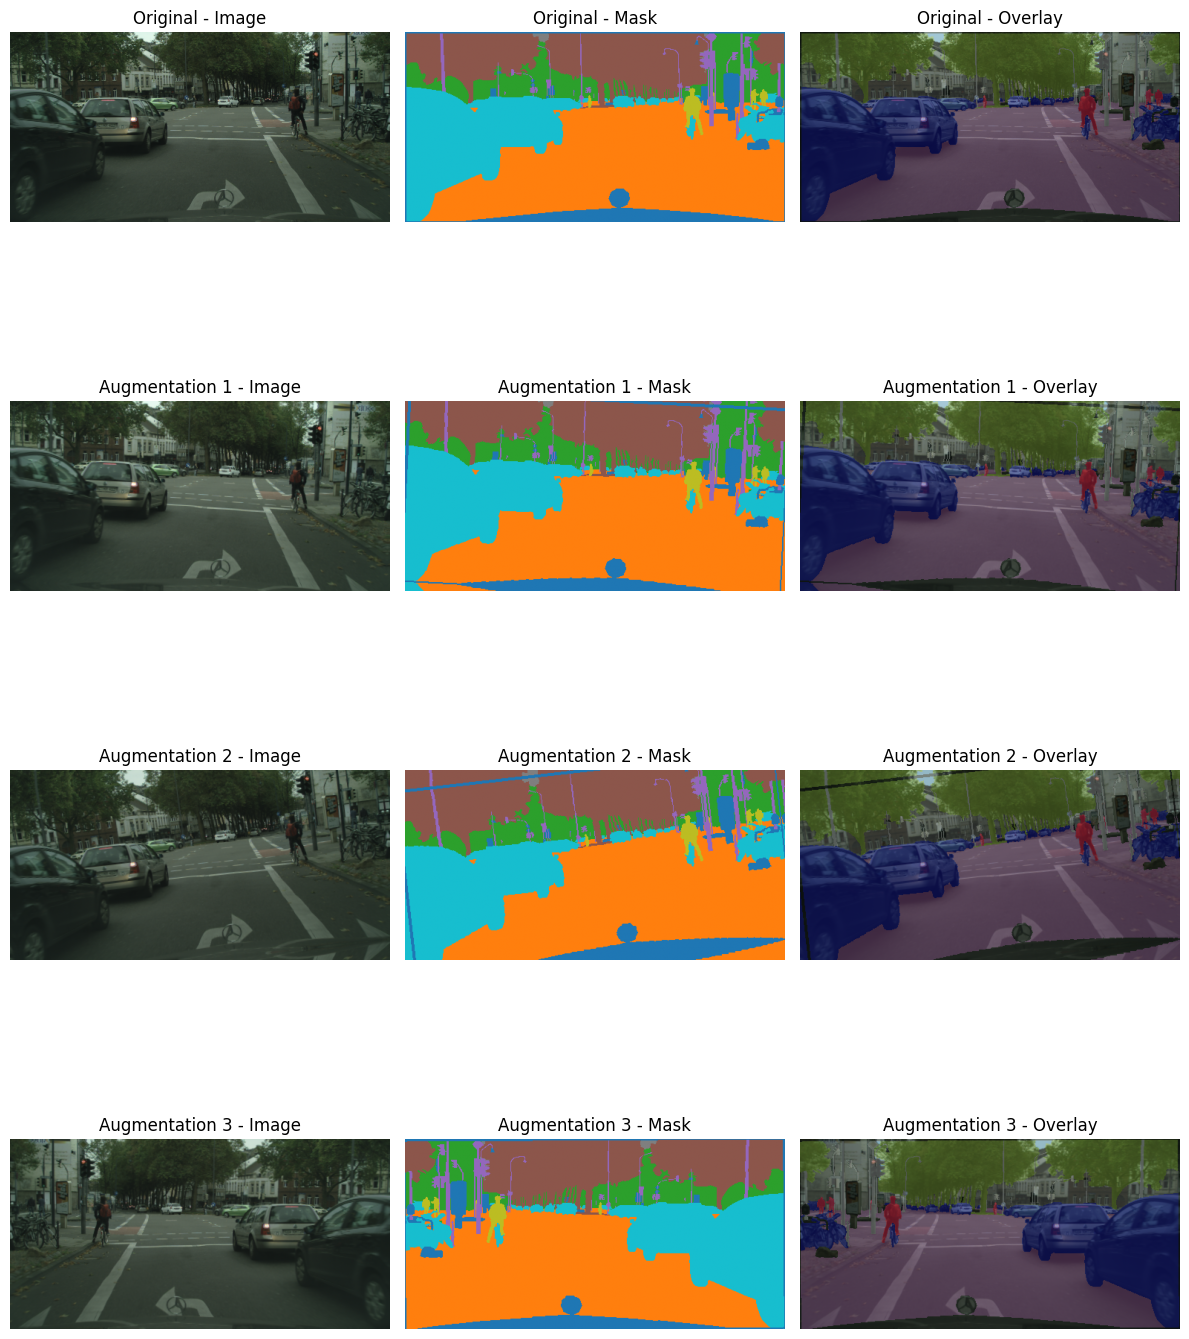

In [10]:
def visualize_augmentation(sample, augmenter, n_examples=4):
    """Visualise plusieurs augmentations d'une meme image."""
    img = load_image(sample['image'])
    mask = load_label(sample['label'])
    
    fig, axes = plt.subplots(n_examples, 3, figsize=(12, 4*n_examples))
    
    for i in range(n_examples):
        if i == 0:
            img_aug, mask_aug = img.copy(), mask.copy()
            title = "Original"
        else:
            img_aug, mask_aug = augmenter(img.copy(), mask.copy())
            title = f"Augmentation {i}"
        
        # Image
        axes[i, 0].imshow(img_aug)
        axes[i, 0].set_title(f"{title} - Image")
        axes[i, 0].axis('off')
        
        # Mask
        axes[i, 1].imshow(mask_aug, cmap='tab10', vmin=0, vmax=7)
        axes[i, 1].set_title(f"{title} - Mask")
        axes[i, 1].axis('off')
        
        # Overlay
        mask_colored = np.zeros((*mask_aug.shape, 3), dtype=np.float32)
        for cat_id, info in CATEGORIES.items():
            mask_colored[mask_aug == cat_id] = np.array(info['color']) / 255.0
        overlay = img_aug * 0.6 + mask_colored * 0.4
        axes[i, 2].imshow(overlay)
        axes[i, 2].set_title(f"{title} - Overlay")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_augmentation(train_data[10], augmenter)

## 6. Data Generator Keras

In [11]:
class CityscapesGenerator(Sequence):
    """
    Generateur de donnees Keras pour le dataset Cityscapes.
    
    Herite de Sequence pour le multiprocessing et le shuffling.
    """
    
    def __init__(self, 
                 data,
                 batch_size=8,
                 target_size=(256, 512),
                 n_classes=8,
                 augmentation=None,
                 shuffle=True,
                 one_hot=True):
        """
        Args:
            data: Liste de dicts avec 'image' et 'label' paths
            batch_size: Taille des batches
            target_size: (height, width) des images de sortie
            n_classes: Nombre de classes
            augmentation: Instance de DataAugmentation ou None
            shuffle: Melanger les donnees a chaque epoque
            one_hot: Retourner les masks en one-hot encoding
        """
        self.data = data
        self.batch_size = batch_size
        self.target_size = target_size
        self.n_classes = n_classes
        self.augmentation = augmentation
        self.shuffle = shuffle
        self.one_hot = one_hot
        self.indexes = np.arange(len(self.data))
        
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        """Nombre de batches par epoque."""
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, index):
        """Genere un batch de donnees."""
        # Indices pour ce batch
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Charger les donnees
        batch_images = []
        batch_masks = []
        
        for idx in batch_indexes:
            sample = self.data[idx]
            
            # Charger image et mask
            image = load_image(sample['image'], self.target_size)
            mask = load_label(sample['label'], self.target_size)
            
            # Appliquer l'augmentation
            if self.augmentation:
                image, mask = self.augmentation(image, mask)
            
            batch_images.append(image)
            batch_masks.append(mask)
        
        # Convertir en arrays
        X = np.array(batch_images, dtype=np.float32)
        
        if self.one_hot:
            y = np.array([mask_to_onehot(m, self.n_classes) for m in batch_masks], dtype=np.float32)
        else:
            y = np.array(batch_masks, dtype=np.int32)
        
        return X, y
    
    def on_epoch_end(self):
        """Appele a la fin de chaque epoque."""
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def get_sample(self, index):
        """Recupere un echantillon specifique (pour visualisation)."""
        sample = self.data[index]
        image = load_image(sample['image'], self.target_size)
        mask = load_label(sample['label'], self.target_size)
        return image, mask, sample

In [12]:
# Creer les generateurs
train_augmentation = DataAugmentation(
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    contrast_range=(0.9, 1.1),
    rotation_range=5
)

train_generator = CityscapesGenerator(
    train_data,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    augmentation=train_augmentation,
    shuffle=True
)

val_generator = CityscapesGenerator(
    val_data,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    augmentation=None,
    shuffle=False
)

test_generator = CityscapesGenerator(
    test_data,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    augmentation=None,
    shuffle=False
)

print(f"Train generator: {len(train_generator)} batches")
print(f"Val generator: {len(val_generator)} batches")
print(f"Test generator: {len(test_generator)} batches")

Train generator: 372 batches
Val generator: 63 batches
Test generator: 191 batches


In [13]:
# Test du generateur
X_batch, y_batch = train_generator[0]

print(f"Batch X shape: {X_batch.shape}")
print(f"Batch y shape: {y_batch.shape}")
print(f"X dtype: {X_batch.dtype}, range: [{X_batch.min():.3f}, {X_batch.max():.3f}]")
print(f"y dtype: {y_batch.dtype}, range: [{y_batch.min():.3f}, {y_batch.max():.3f}]")

Batch X shape: (8, 256, 512, 3)
Batch y shape: (8, 256, 512, 8)
X dtype: float32, range: [0.000, 1.000]
y dtype: float32, range: [0.000, 1.000]


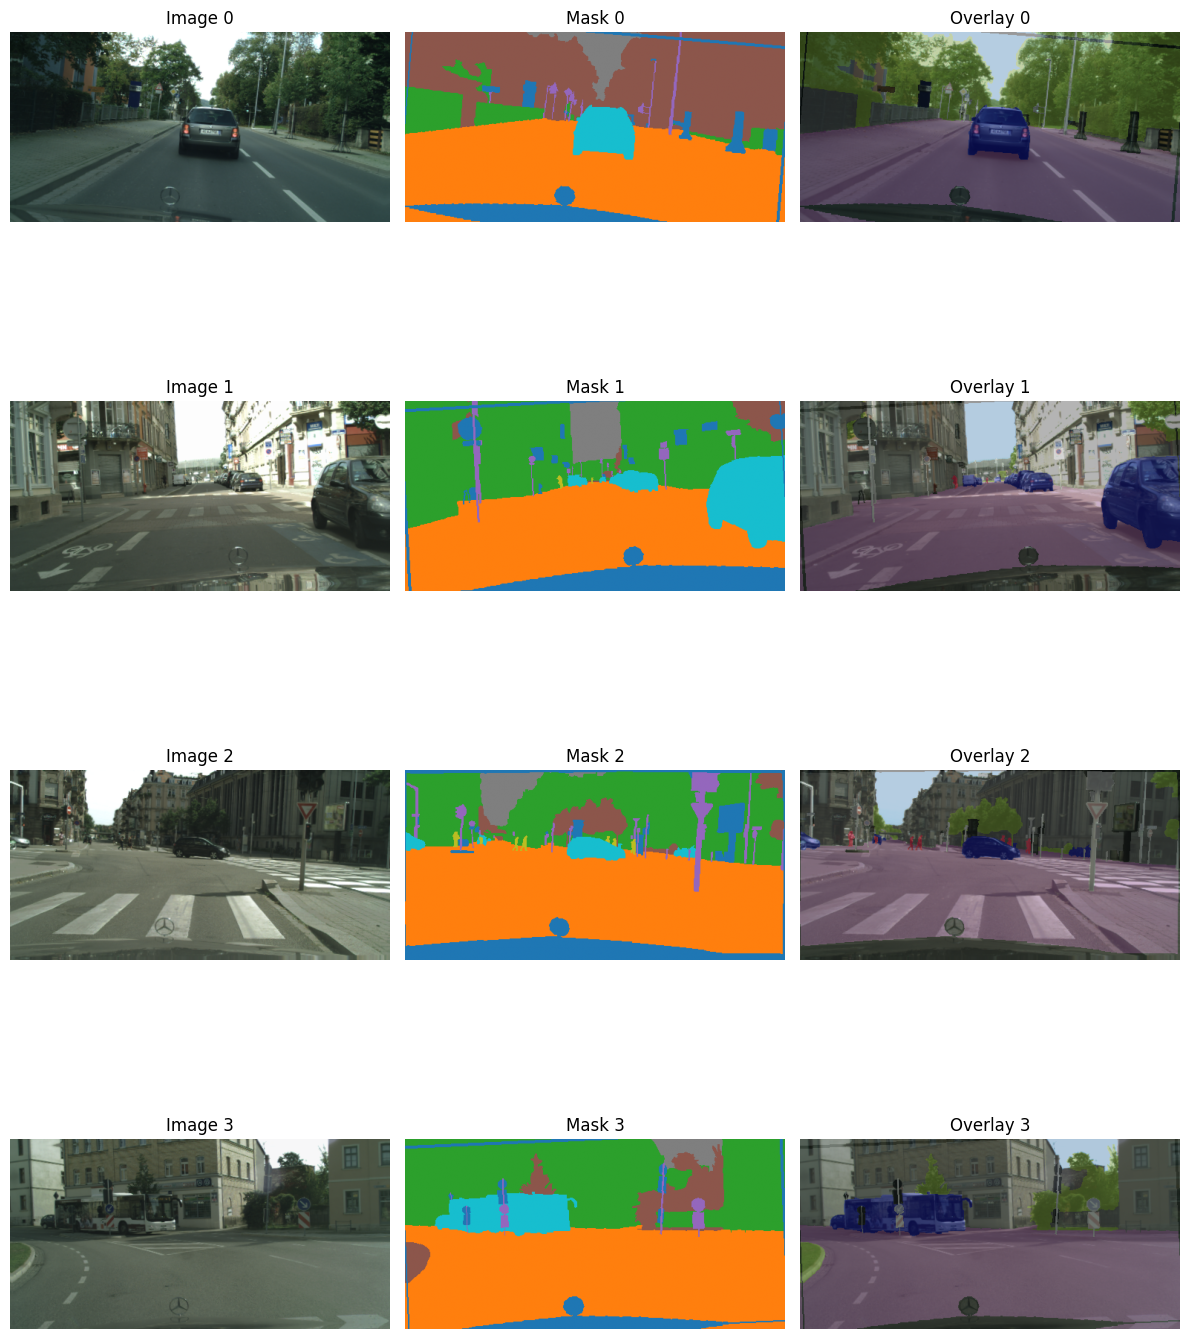

In [14]:
def visualize_batch(generator, batch_idx=0):
    """Visualise un batch de donnees."""
    X, y = generator[batch_idx]
    n_samples = min(4, len(X))
    
    fig, axes = plt.subplots(n_samples, 3, figsize=(12, 4*n_samples))
    
    for i in range(n_samples):
        # Image
        axes[i, 0].imshow(X[i])
        axes[i, 0].set_title(f"Image {i}")
        axes[i, 0].axis('off')
        
        # Mask (argmax du one-hot)
        mask = np.argmax(y[i], axis=-1)
        axes[i, 1].imshow(mask, cmap='tab10', vmin=0, vmax=7)
        axes[i, 1].set_title(f"Mask {i}")
        axes[i, 1].axis('off')
        
        # Overlay
        mask_colored = np.zeros((*mask.shape, 3), dtype=np.float32)
        for cat_id, info in CATEGORIES.items():
            mask_colored[mask == cat_id] = np.array(info['color']) / 255.0
        overlay = X[i] * 0.6 + mask_colored * 0.4
        axes[i, 2].imshow(overlay)
        axes[i, 2].set_title(f"Overlay {i}")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_batch(train_generator, batch_idx=0)

## 7. tf.data Pipeline (Alternative plus performante)

In [15]:
def create_tf_dataset(data, batch_size, target_size, augment=False, shuffle=True):
    """
    Cree un tf.data.Dataset pour des performances optimales.
    
    Args:
        data: Liste de dicts avec 'image' et 'label' paths
        batch_size: Taille des batches
        target_size: (height, width)
        augment: Appliquer l'augmentation
        shuffle: Melanger les donnees
    
    Returns:
        tf.data.Dataset
    """
    image_paths = [d['image'] for d in data]
    label_paths = [d['label'] for d in data]
    
    def load_and_preprocess(img_path, label_path):
        # Charger l'image
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, target_size)
        img = tf.cast(img, tf.float32) / 255.0
        
        # Charger le mask
        mask = tf.io.read_file(label_path)
        mask = tf.image.decode_png(mask, channels=1)
        mask = tf.image.resize(mask, target_size, method='nearest')
        mask = tf.squeeze(mask, axis=-1)
        
        # Convertir vers 8 categories avec tf.gather
        lut_tensor = tf.constant(LUT, dtype=tf.int32)
        mask = tf.cast(mask, tf.int32)
        mask = tf.gather(lut_tensor, mask)
        
        # One-hot encoding
        mask = tf.one_hot(mask, N_CLASSES)
        
        return img, mask
    
    def augment_fn(img, mask):
        # Flip horizontal
        if tf.random.uniform([]) > 0.5:
            img = tf.image.flip_left_right(img)
            mask = tf.image.flip_left_right(mask)
        
        # Brightness
        img = tf.image.random_brightness(img, 0.2)
        img = tf.clip_by_value(img, 0, 1)
        
        # Contrast
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.clip_by_value(img, 0, 1)
        
        return img, mask
    
    # Creer le dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(data))
    
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    
    if augment:
        dataset = dataset.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Creer les datasets tf.data
train_dataset = create_tf_dataset(train_data, BATCH_SIZE, (IMG_HEIGHT, IMG_WIDTH), augment=True, shuffle=True)
val_dataset = create_tf_dataset(val_data, BATCH_SIZE, (IMG_HEIGHT, IMG_WIDTH), augment=False, shuffle=False)

print("tf.data Datasets crees")

tf.data Datasets crees


I0000 00:00:1768557811.004838   26936 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5527 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.9


In [16]:
# Test du tf.data pipeline
for X, y in train_dataset.take(1):
    print(f"tf.data batch X shape: {X.shape}")
    print(f"tf.data batch y shape: {y.shape}")

tf.data batch X shape: (8, 256, 512, 3)
tf.data batch y shape: (8, 256, 512, 8)


2026-01-16 11:03:31.791460: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 8. Sauvegarde de la configuration

In [17]:
# Sauvegarder la configuration complete
config = {
    'img_height': IMG_HEIGHT,
    'img_width': IMG_WIDTH,
    'n_classes': N_CLASSES,
    'batch_size': BATCH_SIZE,
    'categories': {str(k): v['name'] for k, v in CATEGORIES.items()},
    'class_weights': CLASS_WEIGHTS,
    'n_train': len(train_data),
    'n_val': len(val_data),
    'n_test': len(test_data)
}

with open(DATA_DIR / 'config.json', 'w') as f:
    json.dump(config, f, indent=2)

print("Configuration sauvegardee dans data/config.json")
print(json.dumps(config, indent=2))

Configuration sauvegardee dans data/config.json
{
  "img_height": 256,
  "img_width": 512,
  "n_classes": 8,
  "batch_size": 8,
  "categories": {
    "0": "void",
    "1": "flat",
    "2": "construction",
    "3": "object",
    "4": "nature",
    "5": "sky",
    "6": "human",
    "7": "vehicle"
  },
  "class_weights": {
    "0": 0.1,
    "1": 0.5,
    "2": 0.6,
    "3": 1.0,
    "4": 0.7,
    "5": 0.8,
    "6": 1.0,
    "7": 1.0
  },
  "n_train": 2975,
  "n_val": 500,
  "n_test": 1525
}


## 9. Resume et Export des fonctions

In [18]:
# Sauvegarder les fonctions utilitaires dans un module Python
utils_code = '''
"""Utilitaires pour le projet de segmentation Cityscapes."""

import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from pathlib import Path

# Configuration
IMG_HEIGHT = 256
IMG_WIDTH = 512
N_CLASSES = 8

CATEGORIES = {
    0: {\'name\': \'void\', \'color\': (0, 0, 0)},
    1: {\'name\': \'flat\', \'color\': (128, 64, 128)},
    2: {\'name\': \'construction\', \'color\': (70, 70, 70)},
    3: {\'name\': \'object\', \'color\': (153, 153, 153)},
    4: {\'name\': \'nature\', \'color\': (107, 142, 35)},
    5: {\'name\': \'sky\', \'color\': (70, 130, 180)},
    6: {\'name\': \'human\', \'color\': (220, 20, 60)},
    7: {\'name\': \'vehicle\', \'color\': (0, 0, 142)}
}

LABEL_TO_CATEGORY = {
    0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0,
    7: 1, 8: 1, 9: 1, 10: 1,
    11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2,
    17: 3, 18: 3, 19: 3, 20: 3,
    21: 4, 22: 4,
    23: 5,
    24: 6, 25: 6,
    26: 7, 27: 7, 28: 7, 29: 7, 30: 7, 31: 7, 32: 7, 33: 7,
}

# LUT pour conversion rapide
LUT = np.zeros(256, dtype=np.uint8)
for label_id, cat_id in LABEL_TO_CATEGORY.items():
    LUT[label_id] = cat_id


def load_image(path, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    """Charge et preprocesse une image."""
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (target_size[1], target_size[0]), interpolation=cv2.INTER_LINEAR)
    img = img.astype(np.float32) / 255.0
    return img


def load_label(path, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    """Charge et convertit un mask en 8 categories."""
    mask = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (target_size[1], target_size[0]), interpolation=cv2.INTER_NEAREST)
    mask = LUT[mask]
    return mask


def mask_to_onehot(mask, n_classes=N_CLASSES):
    """Convertit un mask en one-hot."""
    return np.eye(n_classes, dtype=np.float32)[mask]


def mask_to_rgb(mask):
    """Convertit un mask en image RGB coloree."""
    rgb = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for cat_id, info in CATEGORIES.items():
        rgb[mask == cat_id] = info[\'color\']
    return rgb
'''

# Creer le dossier src s'il n'existe pas
src_dir = Path('../src')
src_dir.mkdir(exist_ok=True)

with open(src_dir / 'utils.py', 'w') as f:
    f.write(utils_code)

print("Module utils.py sauvegarde dans src/")

Module utils.py sauvegarde dans src/


In [19]:
print("\n" + "="*60)
print("RESUME - PREPARATION DES DONNEES")
print("="*60)
print(f"\nImages: {IMG_WIDTH}x{IMG_HEIGHT} pixels")
print(f"Classes: {N_CLASSES} categories")
print(f"Batch size: {BATCH_SIZE}")
print(f"\nDatasets:")
print(f"  - Train: {len(train_data)} images ({len(train_generator)} batches)")
print(f"  - Val: {len(val_data)} images ({len(val_generator)} batches)")
print(f"  - Test: {len(test_data)} images ({len(test_generator)} batches)")
print(f"\nFichiers crees:")
print(f"  - data/train_paths.csv")
print(f"  - data/val_paths.csv")
print(f"  - data/test_paths.csv")
print(f"  - data/config.json")
print(f"  - src/utils.py")
print(f"\nData augmentation:")
print(f"  - Flip horizontal")
print(f"  - Brightness jittering")
print(f"  - Contrast jittering")
print(f"  - Rotation legere")


RESUME - PREPARATION DES DONNEES

Images: 512x256 pixels
Classes: 8 categories
Batch size: 8

Datasets:
  - Train: 2975 images (372 batches)
  - Val: 500 images (63 batches)
  - Test: 1525 images (191 batches)

Fichiers crees:
  - data/train_paths.csv
  - data/val_paths.csv
  - data/test_paths.csv
  - data/config.json
  - src/utils.py

Data augmentation:
  - Flip horizontal
  - Brightness jittering
  - Contrast jittering
  - Rotation legere


## Prochaines etapes

1. **Notebook 03**: Architecture du modele (U-Net avec backbone)
2. **Notebook 04**: Entrainement et callbacks
3. **Notebook 05**: Evaluation et metriques (IoU, Dice)